In [1]:
from utils2 import getSynteticData, exactTest, MWU, ttests, multiple_plot, getdf
import numpy as np
import pandas as pd

In [2]:
%load_ext cython
%load_ext rpy2.ipython



R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.3.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375227 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
def getPrediction(A,B):
    Data = dict()
    
    Data["eList"] = exactTest(B, A, 35, False)
    Data["fpList"] = fastPerm(np.array(A),np.array(B))
    Data["mwuList"] = MWU(A, B, False)
    Data["ttList"] = ttests(A, B, False)
    
    Data["eVttDf"] = pd.DataFrame(data=
                                  {'Parallel Green': Data["eList"], 'Ttest': Data["ttList"] })
    Data["mwuVttDf"] = pd.DataFrame(data={'Mann–Whitney U-test': Data["mwuList"], 'Ttest': Data["ttList"]})
    Data["eVmwuDf"] = pd.DataFrame(data={'Parallel Green': Data["eList"], 'Mann–Whitney U-test': Data["mwuList"]})

    Data["eVfpDf"] = pd.DataFrame(data={'Parallel Green': Data["eList"], 'FastPerm': Data["fpList"]})
    Data["mwuVfpDf"] = pd.DataFrame(data={'Mann–Whitney U-test': Data["mwuList"], 'FastPerm': Data["fpList"]})
    Data["ttVfpDf"] = pd.DataFrame(data={'Ttest': Data["ttList"], 'FastPerm': Data["fpList"]})
                                                      
    return Data

    

    

# $A \sim N(0,1)\ and B \sim N(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [7]:
np.random.seed(10)
S = 20_000

In [8]:
AN, BN = getSynteticData(np.random.normal,mean=0,sampleN=S)
%time DataNormNoDiff = getPrediction(AN, BN)

CPU times: user 52min 24s, sys: 1.99 s, total: 52min 26s
Wall time: 52min 25s


In [9]:
normfpDf = getdf(DataNormNoDiff["fpList"], S, "FastPerm")
normexactDf = getdf(DataNormNoDiff["eList"], S, "Parallel Green")
normttDf = getdf(DataNormNoDiff["ttList"], S, "$\it{T}$ test")
normmwuDf = getdf(DataNormNoDiff["mwuList"], S, "Mann–Whitney $\it{U}$ test")

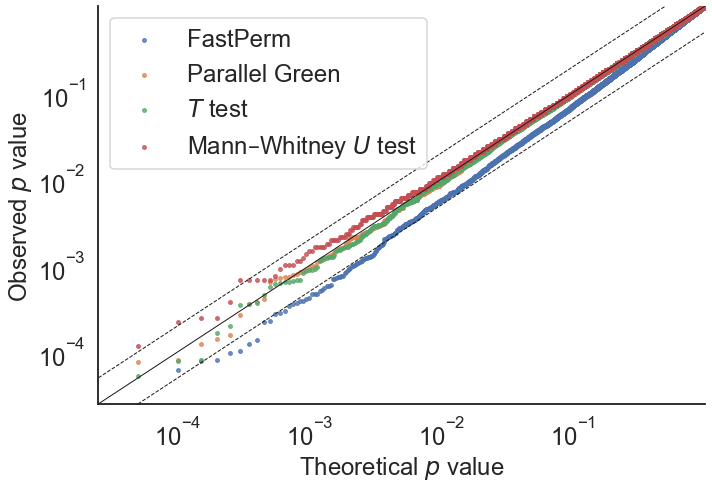

In [15]:
multiple_plot(pd.concat((normfpDf, normexactDf, normttDf, normmwuDf)), "figures/calibration/allTests_0_1_50")
              
              

# $A \sim logN(0,1)\ and B \sim logN(0,1)$. $ |A|=20$ and $|B|=20$ with $2000$ samples.

In [11]:
AN, BN = getSynteticData(np.random.lognormal, mean=0, sampleN=S)
DataLogNormNonDiff = getPrediction(AN, BN)

In [12]:
logfpDf = getdf(DataLogNormNonDiff["fpList"], S, "FastPerm")
logexactDf = getdf(DataLogNormNonDiff["eList"], S, "Parallel Green")
logttDf = getdf(DataLogNormNonDiff["ttList"], S, "$\it{T}$ test")
logmwuDf = getdf(DataLogNormNonDiff["mwuList"], S, "Mann–Whitney $\it{U}$ test")

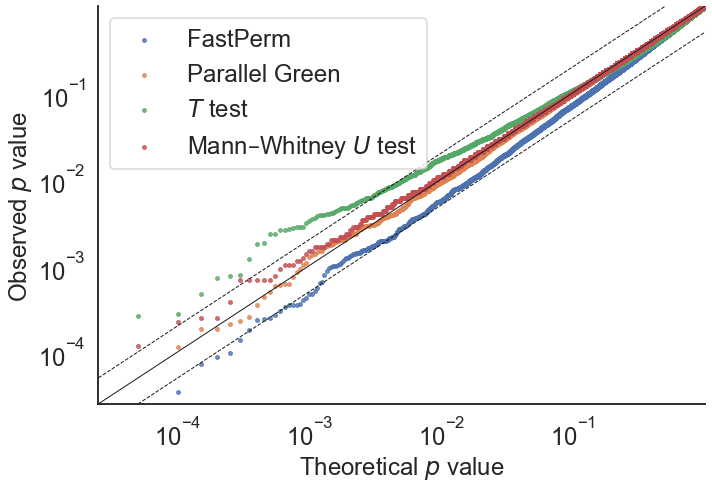

In [16]:
multiple_plot(pd.concat((logfpDf, logexactDf, logttDf, logmwuDf)), "figures/calibration/allTestsLog_0_1_50")
